# Dynamic Convolutional Neural Network
***
# Table of Contents
1.   [Imports](#Imports)
2.   [Dataset Object](#Dataset-Object)
3.   [Data Loading](#Data-Loading)
4.   [Model](#Model)
5.   [Setup](#Setup)
6.   [Training](#Training)
7.   [Testing](#Testing)

# Imports

The necessary libraries are imported at this stage.

* torch - Python pytorch library used to create and train the CNN
* numpy - Efficient data arrays
* pandas - Data applications
* sklearn - Provides a number of models, metrics and general functionality for machine learning.
* matplotlib - Provides plotting.

In [1]:
import torch
import numpy as np
import pandas as pd
from torch.nn import Linear, Conv1d, MaxPool1d, Module, CrossEntropyLoss, Dropout
from torch.optim import Adam
from torch.utils.data import Dataset
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score, confusion_matrix
import Helper as h
from sklearn.utils import shuffle

# Dataset Object

Although not fully required it is helpful to create a custom torch.utils.data.Dataset when using the pytorch library.
This makes the splitting and feeding of data into the network easier.

## Encoding

A dict is defined 0-2 for the Dynamic activities in the dataset.

In [2]:
activity_encode =   {
                        "WALKING": 0,
                        "STAIRS DN": 1,
                        "STAIRS UP": 2,
                        "SWIMMING" : 3,
                        "PUSH UP" : 4,
                        "JUMPING" : 5,
                        "DRIVING": 6,
                        "LAYING": 7,
                        "SITTING": 8,
                        "STANDING": 9
                    }

## Dataset

The object is defined as below for the UCI dataset. 3 functions need to be implemented **__init__**, **__len__** and
**__getitem__**.

In initialisation the data is split into X and y variables and turned into tensors.

The X variable has shape (row_count, 1, feature_count). 1 since there is only one channel of data.

The static features are removed.

In [3]:
class OUR_Dynamic_Dataset(Dataset):
    """UCI dataset."""

    def __init__(self, csv_file, train=False):
        data = pd.read_csv(csv_file)

        data['Label'] = data['Label'].map(activity_encode)
        data, _ = [x for _, x in data.groupby(data['Label'] > 5)]
        if train:
            # shuffle data
            data = shuffle(data)
            # Get label value counts
            temp = data["Label"].value_counts()
            # Get the smallest value/ smallest feature count
            smallestV = int(temp.values[-1])
            # define counts
            label_counts = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
            # add each index to its label
            labels = data["Label"]
            for i, label in enumerate(labels):
                label_counts[label].append(i)
            # re define data dataframe by slicing indices
            new_df = pd.DataFrame(columns=data.columns)
            for label in label_counts:
                new_df = new_df.append(data.iloc[label_counts[label][:smallestV]])

            # return data as with even distribution
            new_df.to_csv('Our Dataset/train_even.csv', index=False)
            data = new_df.copy()

        self.data_y = data['Label'].values
        data = pd.DataFrame(data.drop(['Label'],axis=1))
        self.data_x = np.array(data)
        # [batch, channels, features]
        self.data_x = self.data_x.reshape(len(self.data_x), 1, 589)
        self.data_x  = torch.from_numpy(self.data_x)
        self.data_y = self.data_y.astype(int)
        self.data_y = torch.from_numpy(self.data_y)

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        return self.data_x[idx], self.data_y[idx]

Initialise the 3 datasets that will be used.

# 80 train 20 valid

In [4]:
train_data = OUR_Dynamic_Dataset(csv_file='Our Dataset/train.csv', train=True)
valid_data = OUR_Dynamic_Dataset(csv_file='Our Dataset/valid.csv')
test_data = OUR_Dynamic_Dataset(csv_file='Our Dataset/test.csv')

In [5]:
%%capture
h.pie('Our Dataset/train_even.csv', 'OUR Data Dynamic Training Evened Data Distribution', activity_encode, 5, 'Label', encode=False)
h.pie('Our Dataset/train.csv', 'OUR Data Dynamic Training As Collected Data Distribution', activity_encode, 5, 'Label')
h.pie('Our Dataset/valid.csv', 'OUR Data Dynamic Validation Data Distribution', activity_encode, 5, 'Label')
h.pie('Our Dataset/test.csv', 'OUR Data Dynamic Testing Data Distribution', activity_encode, 5, 'Label')

# Data Loading

Using the DataLoader object load in the data, shuffling and assigning a batch size of 64.

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

# Model

The Dynamic CNN is implemented below, documentation is provided in the report.

In [7]:
class DynamicCNN(Module):
    def __init__(self):
        super(DynamicCNN, self).__init__()

        self.conv1 = Conv1d(1, 100, kernel_size=tuple([3]))
        self.pool = MaxPool1d(kernel_size=tuple([3]))
        self.fc = Linear(19500, 6)
        self.dropout = Dropout(0.5)

    # Defining the forward pass
    def forward(self, x):
        # print(x.size()) #([64, 1, 589])
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.size()) #([64, 100, 195])
        x = x.view(-1, 19500)
        # print(x.size()) #([64, 19500])
        x = self.dropout(F.log_softmax((self.fc(x))))
        # print(x.size()) #([64, 4])
        return x

# Setup

In this step we initialise the loss, optimizer and model objects. For this problem we used cross entropy loss and the
adam optimizer.

If found we use cuda GPU acceleration to make the process faster.

In [8]:
criterion = CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DynamicCNN().double()

train = True

# Set for training
if train:
    epochs = 11
    step = 1
    optimizer = Adam(model.parameters(), lr=0.00005)
    model.to(device)
# Load Existing, (do not train again if loaded)
else:
    state_dict = torch.load('Models/ODCNN.pth')
    model.load_state_dict(state_dict)

# Training

In this step the model is trained. Validation is done so we can observe the progress.

In [9]:
data_loaders = {}
data_loaders['train'] = trainloader
data_loaders['val'] = validloader
data_lengths = {"train": len(train_data), "val": len(valid_data)}
for epoch in range(epochs):
    if (epoch+1) % step == 0:
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:
            inputs, labels = data
            inputs, labels = inputs.to(device).double(), labels.to(device).long()
            # forward pass to get outputs
            output = model(inputs)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output, labels)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.item()

        epoch_loss = running_loss / data_lengths[phase]
        if (epoch+1) % step == 0:
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

Epoch 0/10
----------
train Loss: 29697.4364
val Loss: 7583.0813
Epoch 1/10
----------
train Loss: 6566.1633
val Loss: 3101.1615
Epoch 2/10
----------
train Loss: 3256.3036
val Loss: 2799.3361
Epoch 3/10
----------
train Loss: 2394.5402
val Loss: 1127.6419
Epoch 4/10
----------
train Loss: 2345.5320
val Loss: 1633.2414
Epoch 5/10
----------
train Loss: 2969.8089
val Loss: 7231.2264
Epoch 6/10
----------
train Loss: 3264.4667
val Loss: 2136.1872
Epoch 7/10
----------
train Loss: 3426.8184
val Loss: 1863.5712
Epoch 8/10
----------
train Loss: 3089.6460
val Loss: 1001.1487
Epoch 9/10
----------
train Loss: 1881.3239
val Loss: 1803.0852
Epoch 10/10
----------
train Loss: 1639.6753
val Loss: 1057.5945


c:\users\aiden williams\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Testing

Finally the model is tested on the test set.

In [10]:
model.cpu()
predictions = []
test_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.double(), labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            # print(labels)
            # print(p)
            predictions.append(p)

        for l in labels:
            test_labels.append(l)


c:\users\aiden williams\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


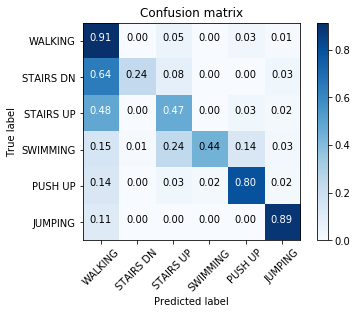

In [11]:
cnf_matrix = confusion_matrix(test_labels, predictions)
np.set_printoptions(precision=2)

classes =   {
                "WALKING": 0,
                "STAIRS DN": 1,
                "STAIRS UP": 2,
                "SWIMMING" : 3,
                "PUSH UP" : 4,
                "JUMPING" : 5,
            }
h.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True,title='Confusion matrix')


In [12]:
# Print metrics
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(test_labels, predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(test_labels, predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(test_labels, predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(test_labels, predictions, average='weighted')))

Final accuracy score on the testing data: 0.6129
Final F-score on the testing data: 0.6427
Final precision score on the testing data: 0.7253
Final recall score on the testing data: 0.6129


In [13]:
# Save model for neutron
device = 'cpu'
batch = next(iter(trainloader))[0].to(device).double()
torch.onnx.export(model, batch, 'Visualizations/CNN ONNX/ODDCNN.onnx', output_names=["Activity"])

c:\users\aiden williams\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [14]:
# save model

torch.save(model.state_dict(), 'Models/ODDCNN.pth')
